In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft #stft
from scipy.signal import butter, sosfiltfilt #signal filtering 
from scipy.interpolate import interp1d
import numpy as npy
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#Load in the file 
file_path = "MU_01_2025-09-29_18_29_50_Muse_Recording.csv"

''' 
nan numbers are preventing the calculation & filtering from working right, Both in MNE and here. 
No connection issues during recording on the android app. 

Scrolling thru in the CSV viewer reveals areas of NaN / 0 for the values...

This must be because the program is receiving bad EEG packets. 
The packet receipt triggers the CSV line write, but bad values go thru. 

This model of Muse, MU_01 unfortunately does not have a 220 Hz  6 channel option!

Before this code can be properly used, we need to fix a MU_01 and get good files to work with. 
'''

#file sampling rate of 500Hz
sfreq = 500

#change to your file path
df = pd.read_csv(file_path)
df.head()

for col_name in df.columns:
    print(col_name)

print(df.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'MU_01_2025-09-30_17_00_03_Muse_Recording.csv'

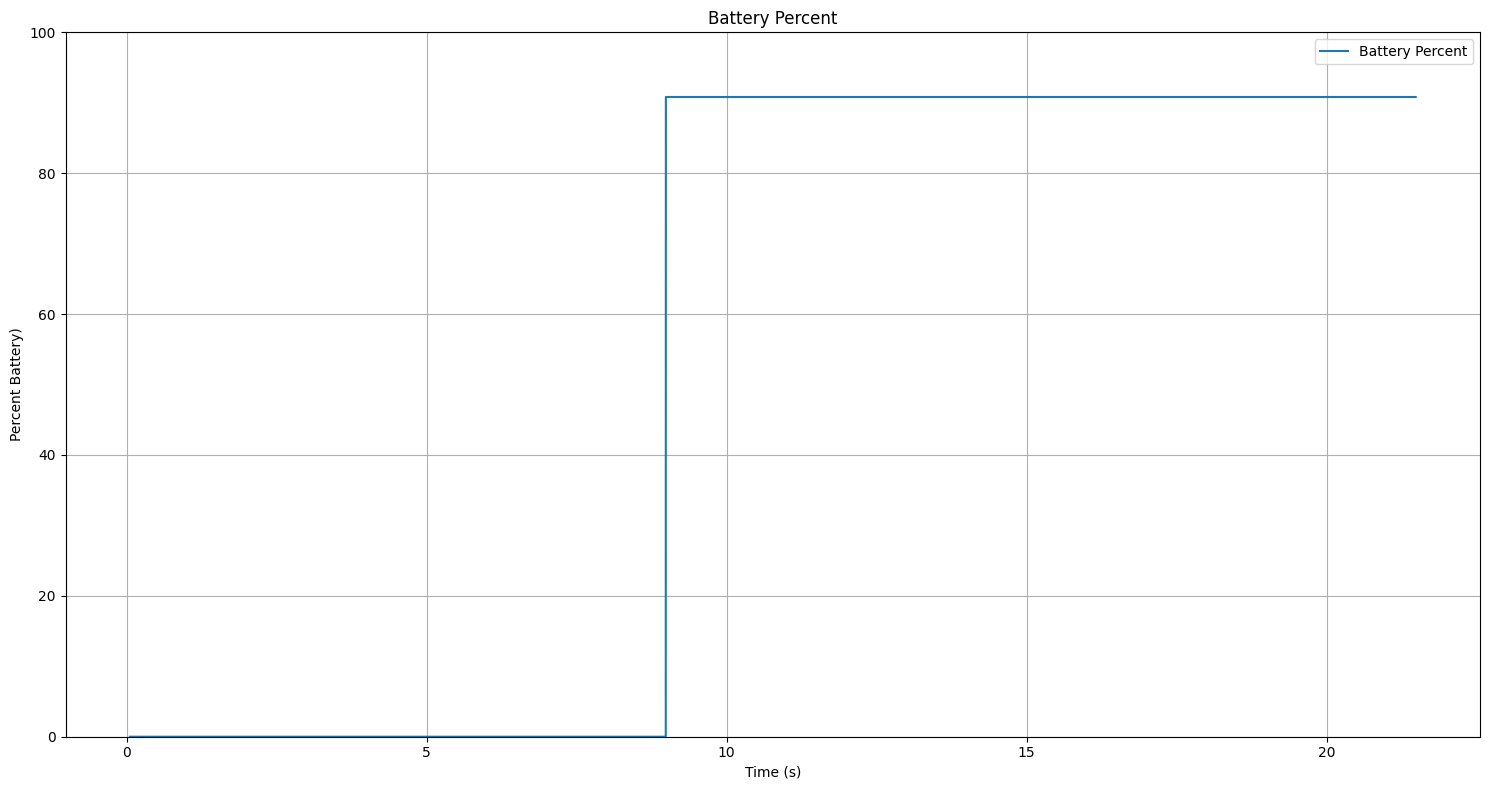

In [ ]:
'''
Battery issues on MU_01 can prevent things from working properly, so start with that. 
'''

time_sec = df["ms_ELAPSED"] / 1000.0

plt.figure(figsize=(15, 8))
plt.plot(time_sec, df['BATTERY_PERCENT'], label="Battery Percent")

plt.ylim(0,100)

plt.xlabel("Time (s)")
plt.ylabel("Percent Battery)")
plt.title(f"Battery Percent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

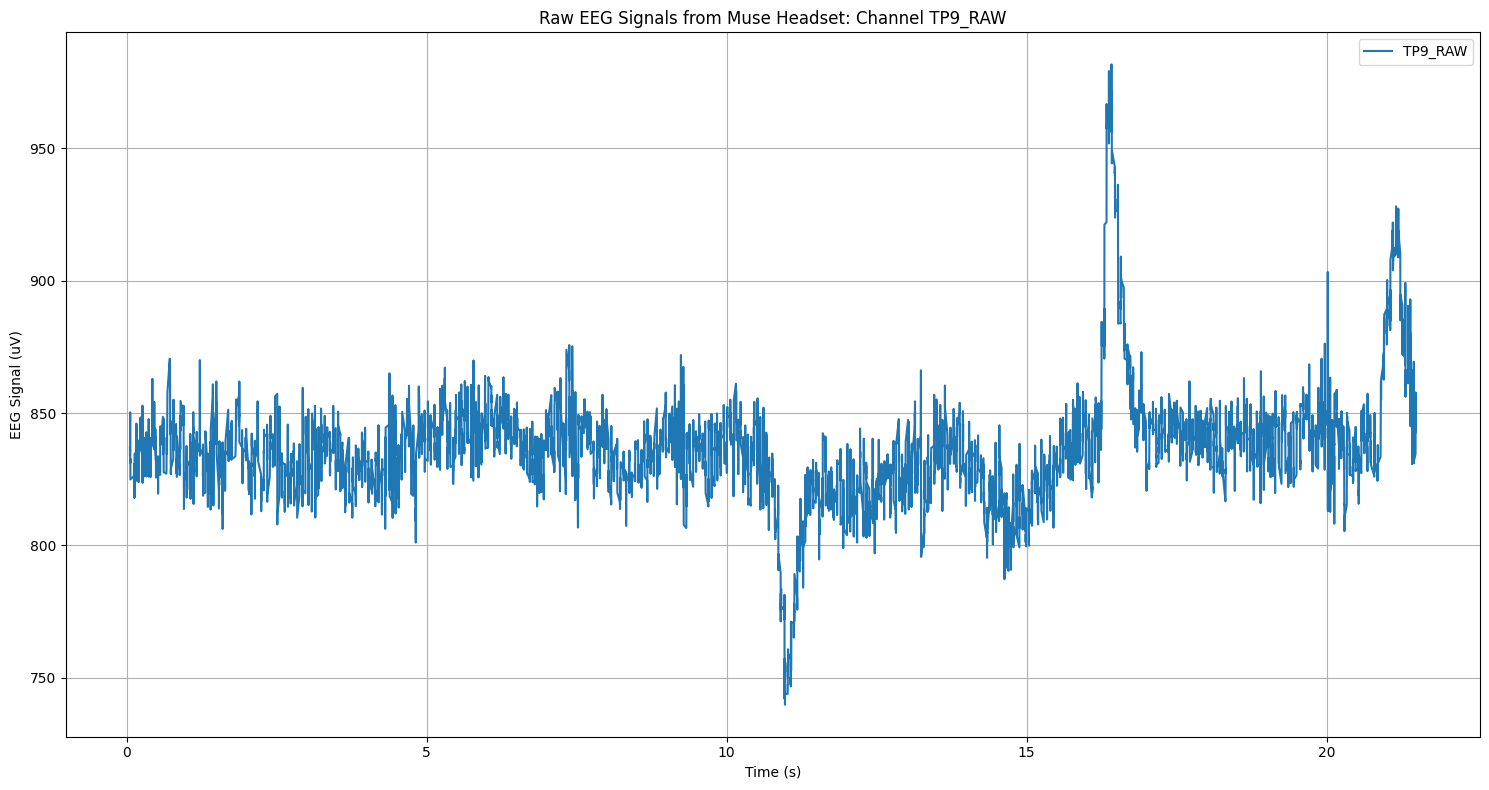

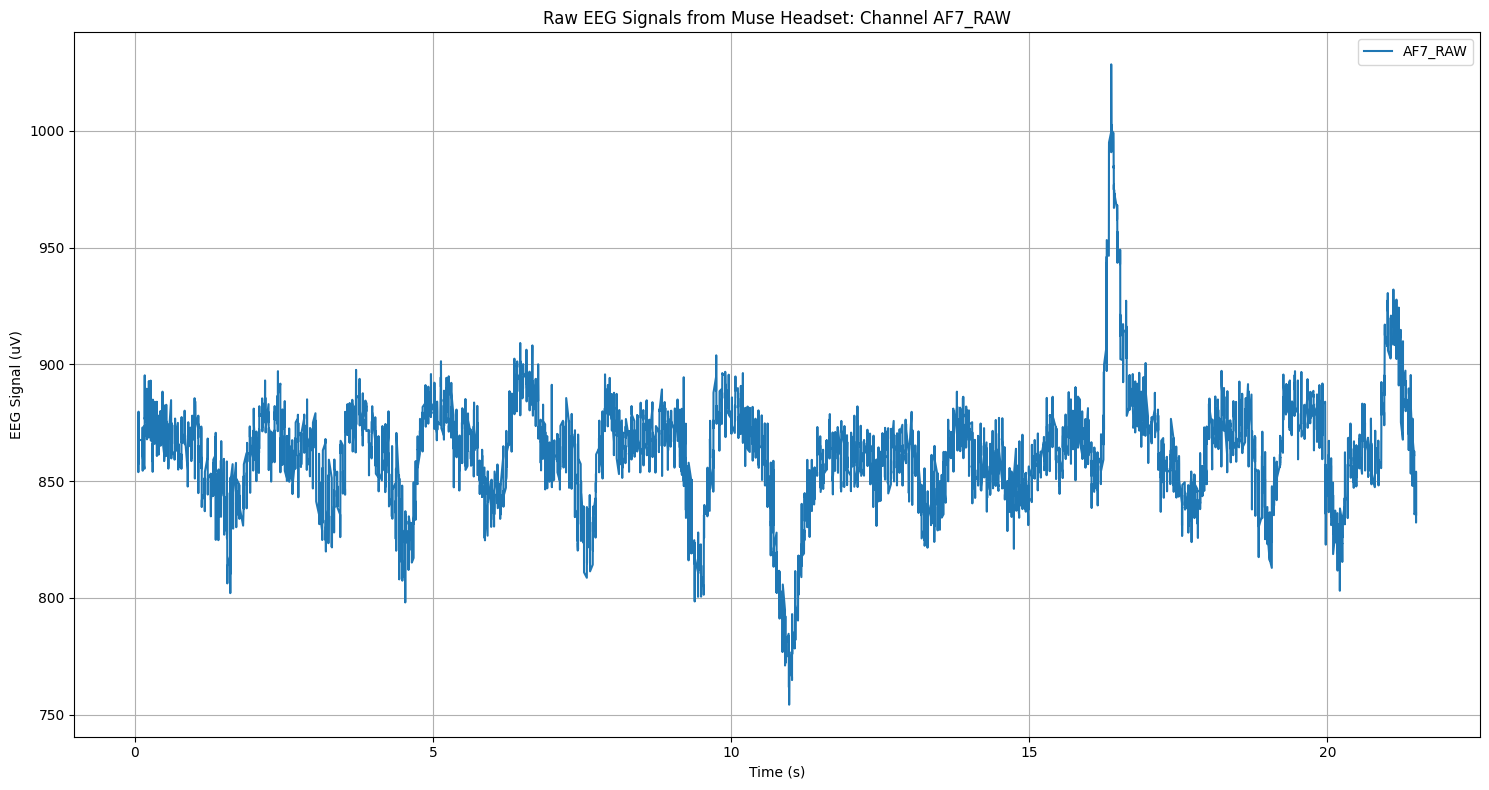

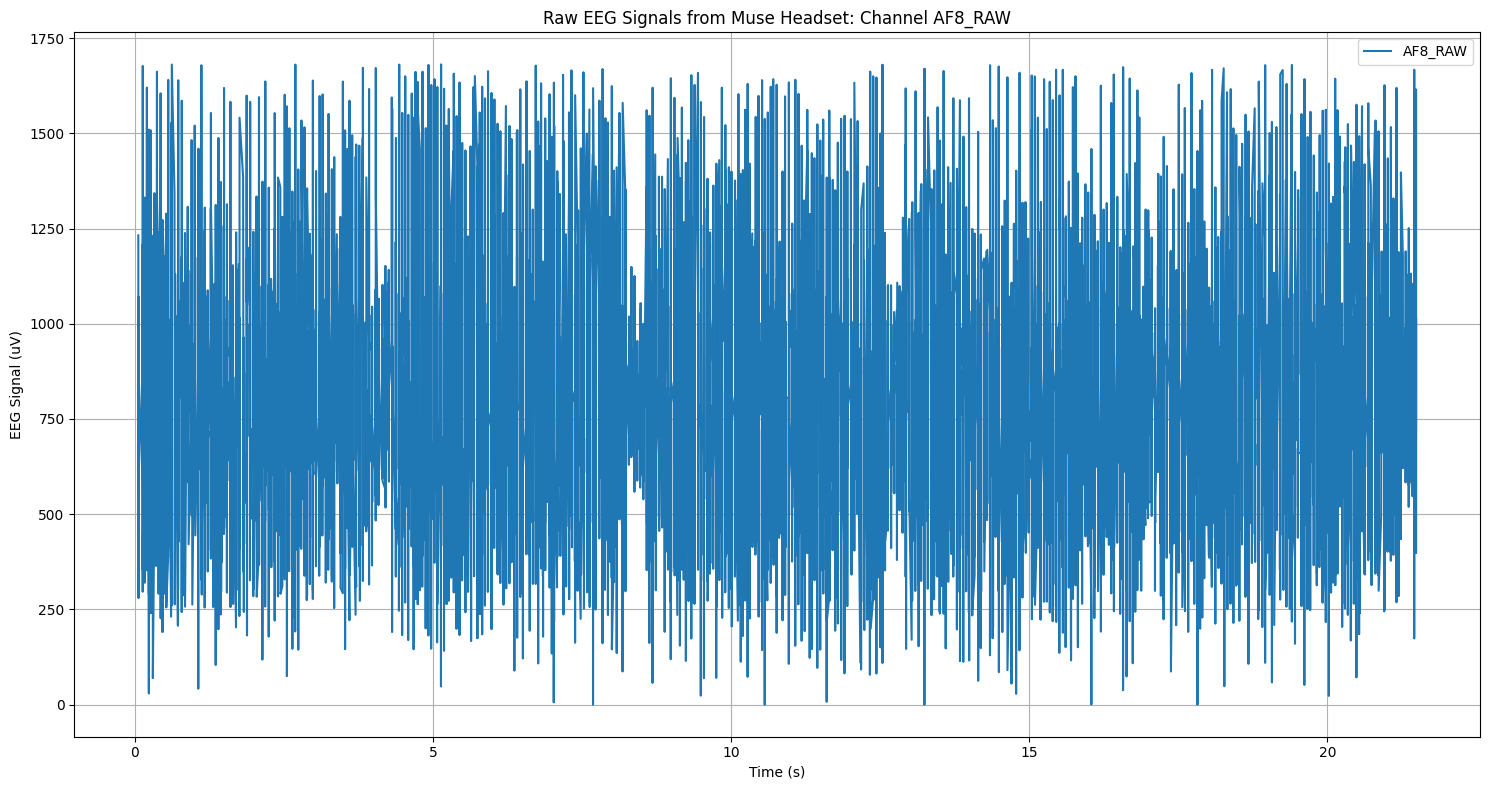

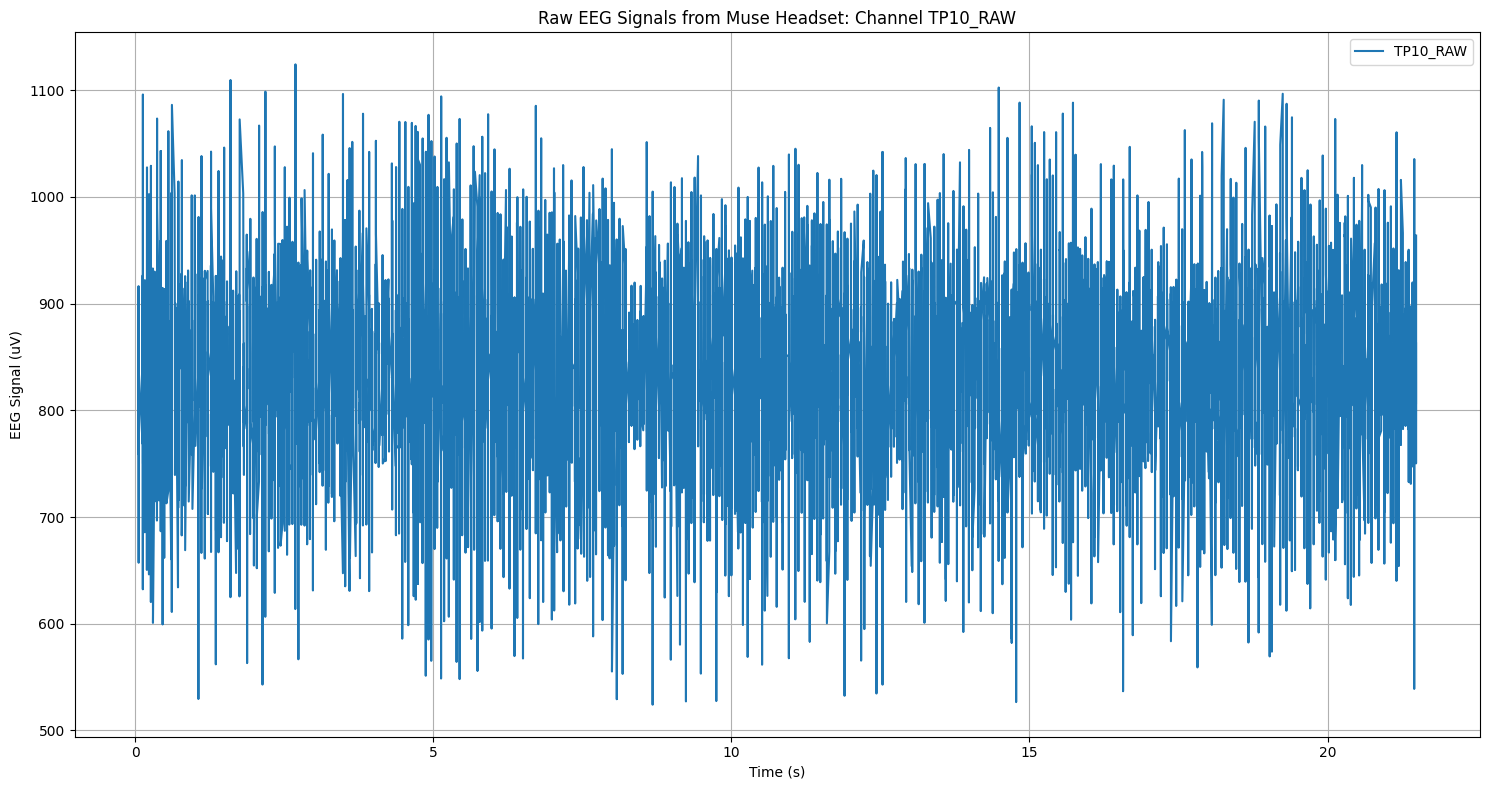

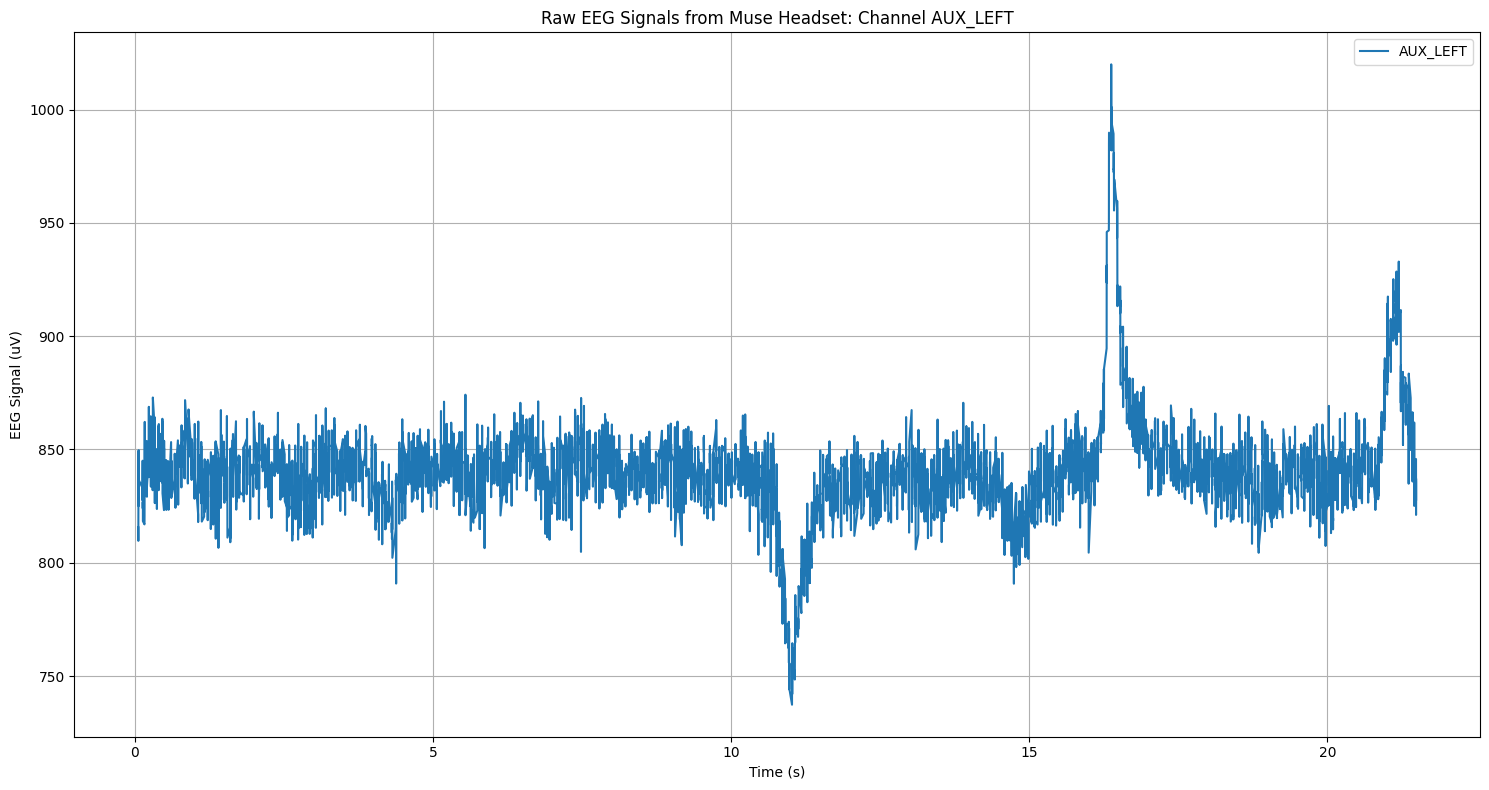

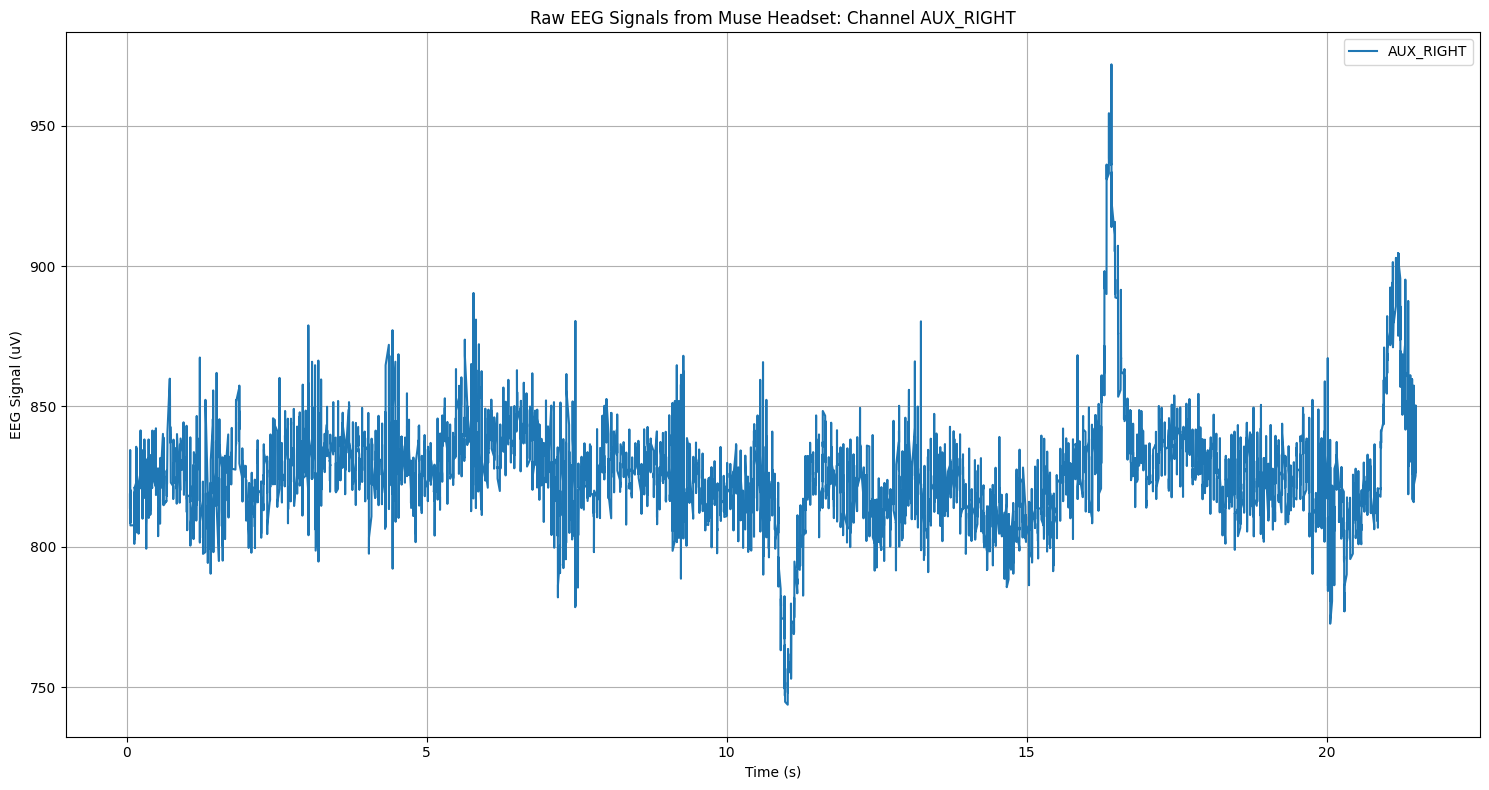

'\nRocklen Notes: \n\n    - Use a SW Notch filter (60Hz) for powerline noise, lots of noise,   \n        - Band pass 50 would also be good \n        -  40uV peak to peak noise is probably induction noise \n    - The electrode that was connected during the first test seems to contain a goodish signal other than the big noise\n\nSteve Notes: \n\n    - Cable bad, make out of flexible cable \n\n'

In [ ]:
time_sec = df["ms_ELAPSED"] / 1000.0
channels = ["TP9_RAW", "AF7_RAW", "AF8_RAW", "TP10_RAW", "AUX_LEFT", "AUX_RIGHT"]

for ch in channels:

    plt.figure(figsize=(15, 8))
    plt.plot(time_sec, df[ch], label=ch)

    #plt.ylim(500,900)

    plt.xlabel("Time (s)")
    plt.ylabel("EEG Signal (uV)")
    plt.title(f"Raw EEG Signals from Muse Headset: Channel {ch}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

'''
Steve Notes: 

    - Cable bad, make out of flexible cable 

'''

Number of samples: 7858
Channel: TP9_RAW
Number of samples - time_sec: 7858, filtered_data: 7858
filtered_data range: -79.84476110776922 to 130.783542637467


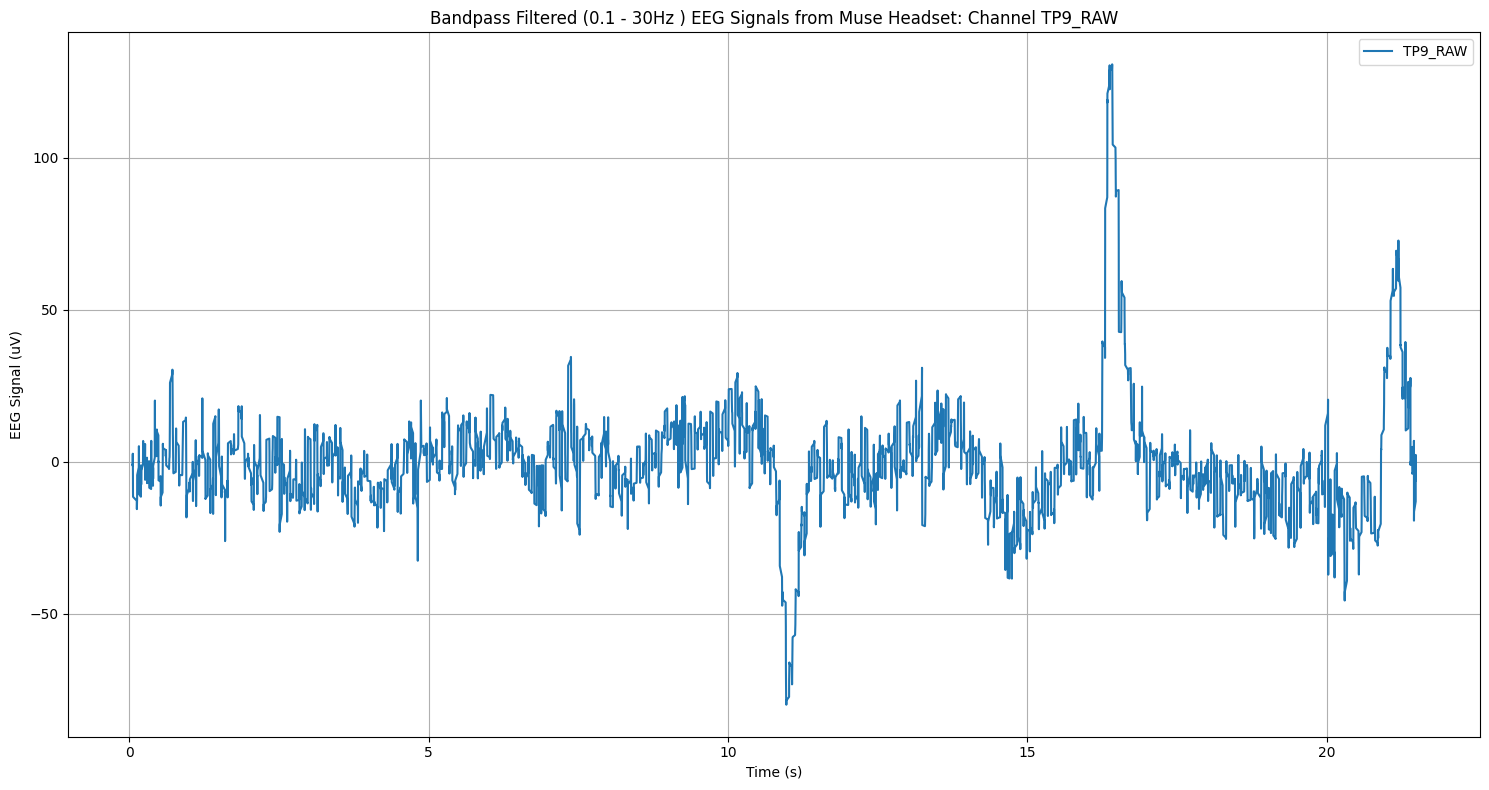

Number of samples: 7858
Channel: AF7_RAW
Number of samples - time_sec: 7858, filtered_data: 7858
filtered_data range: -90.54448042139543 to 148.2546041684808


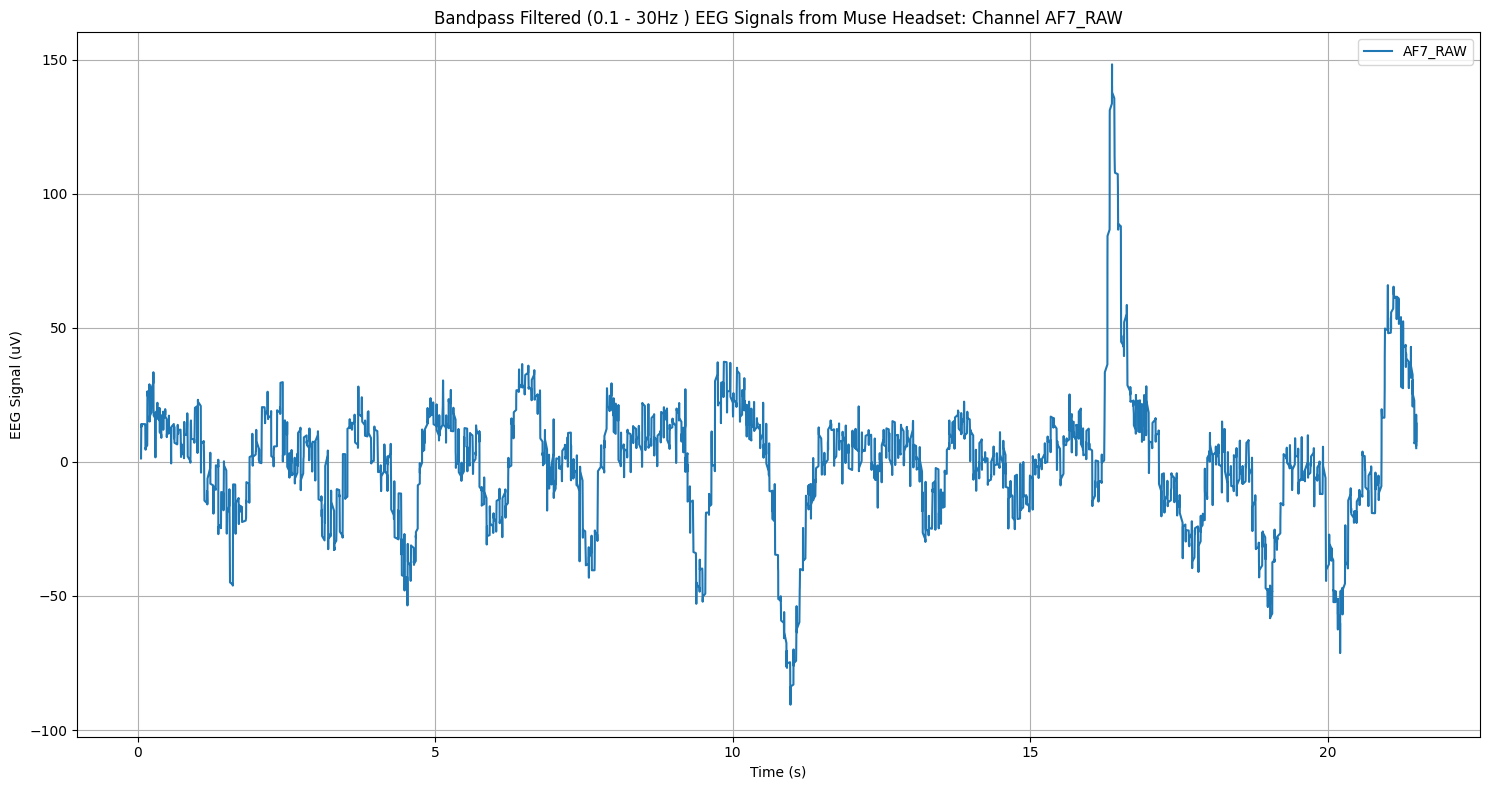

Number of samples: 7858
Channel: AF8_RAW
Number of samples - time_sec: 7858, filtered_data: 7858
filtered_data range: -1375.9584878254634 to 701.0148228258702


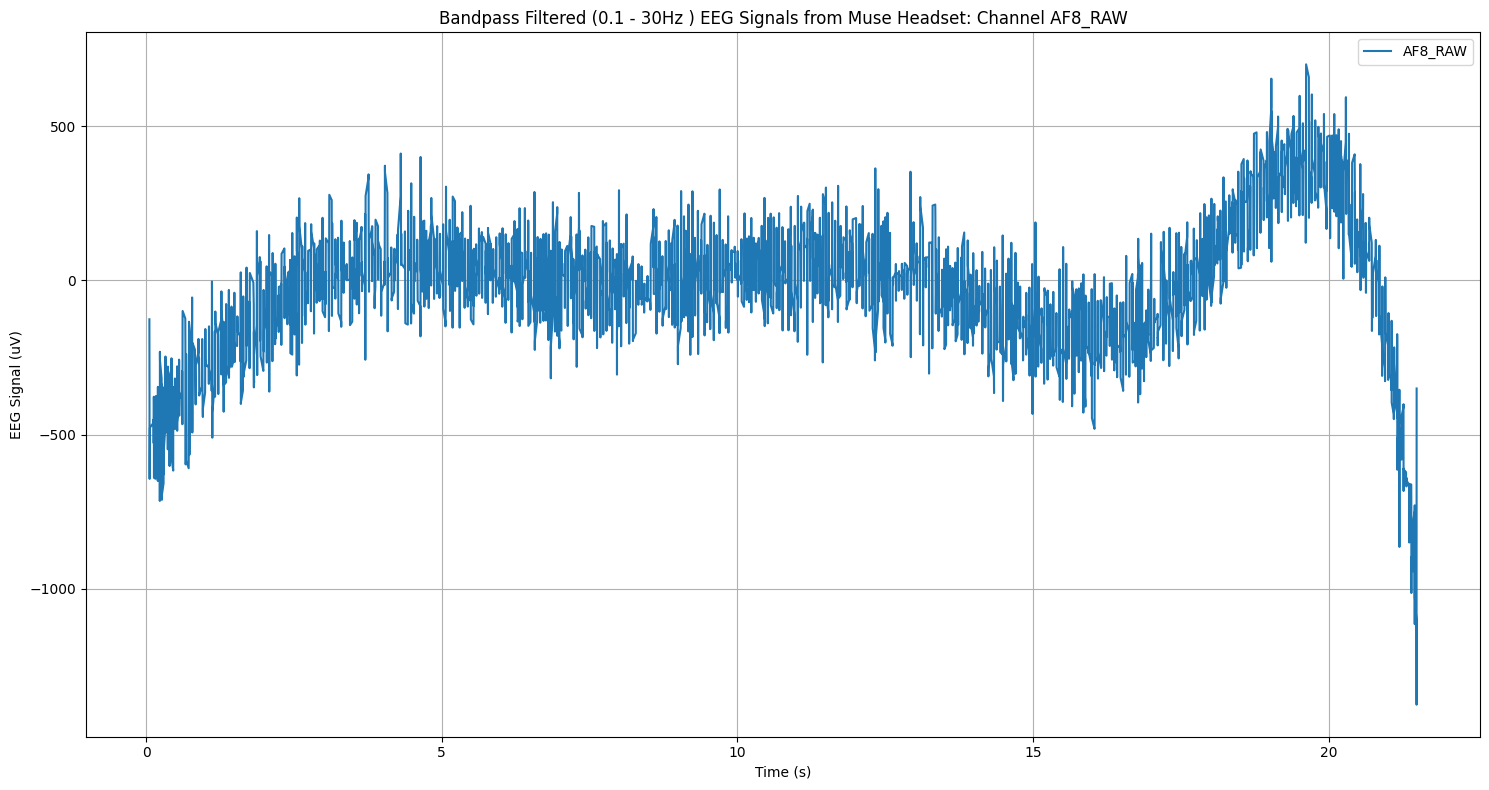

Number of samples: 7858
Channel: TP10_RAW
Number of samples - time_sec: 7858, filtered_data: 7858
filtered_data range: -213.63990439046344 to 145.37678816714674


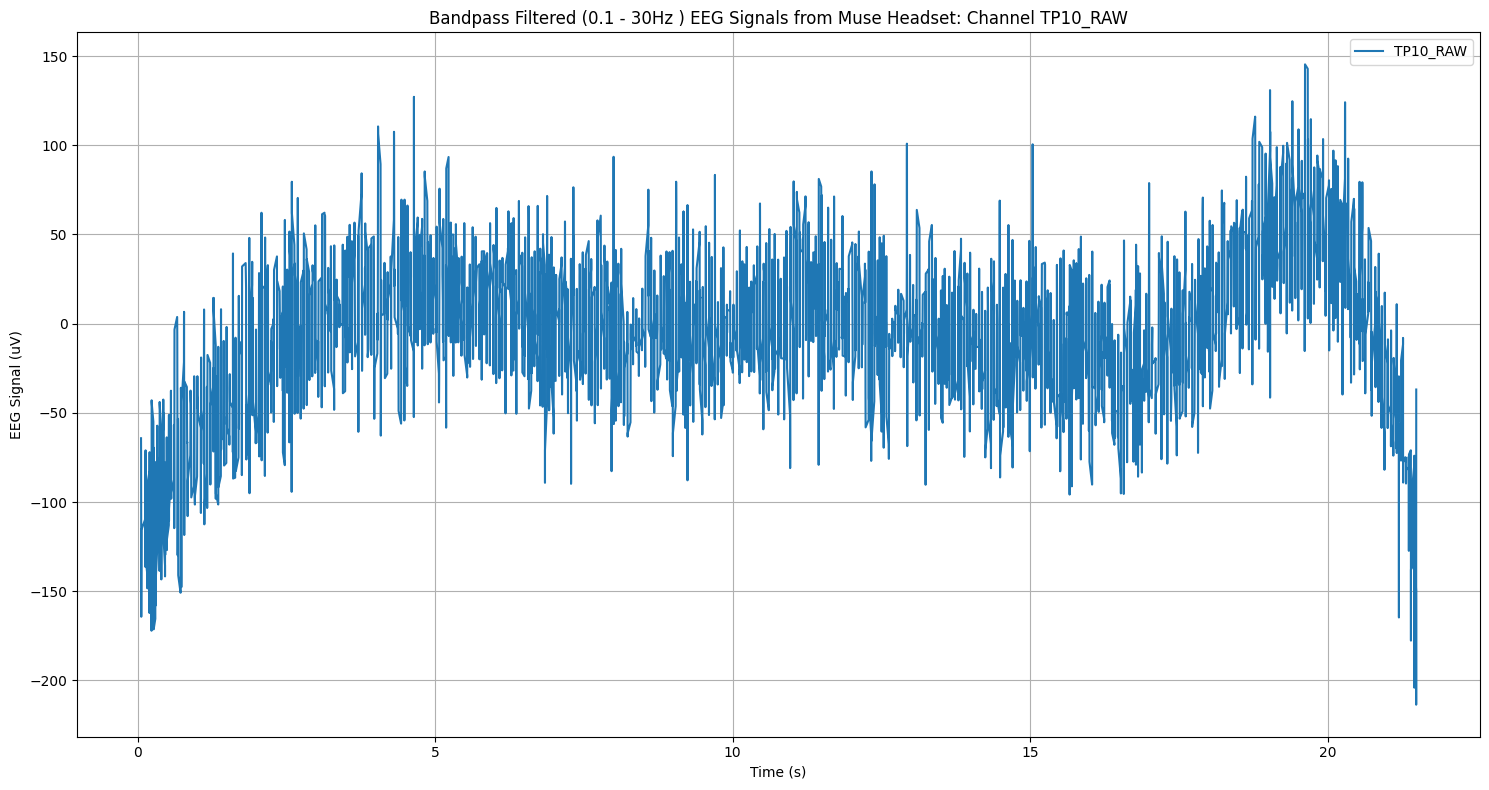

Number of samples: 7858
Channel: AUX_LEFT
Number of samples - time_sec: 7858, filtered_data: 7858
filtered_data range: -85.97660543022265 to 157.53104274430692


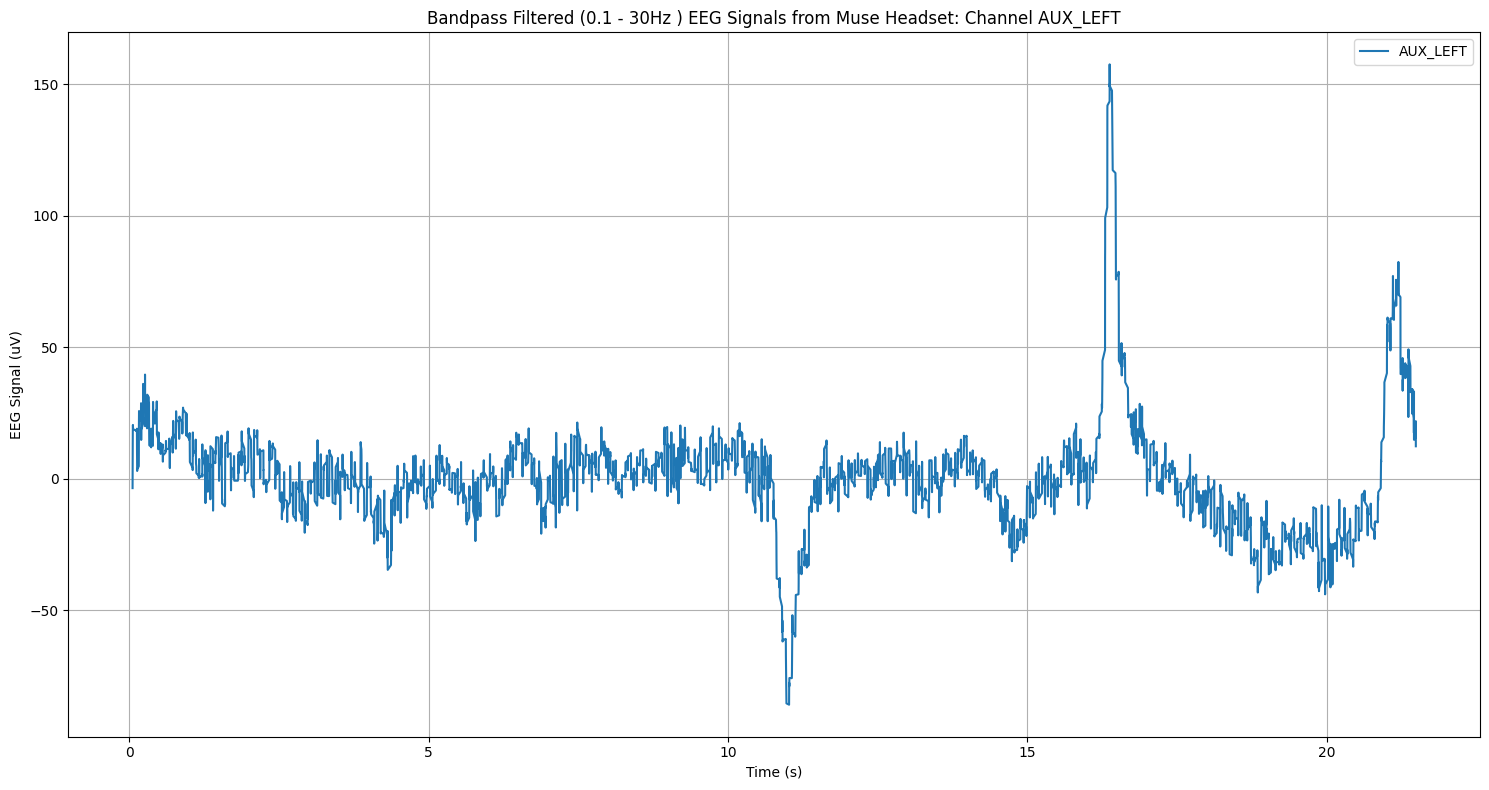

Number of samples: 7858
Channel: AUX_RIGHT
Number of samples - time_sec: 7858, filtered_data: 7858
filtered_data range: -67.65547743065105 to 119.64380757345295


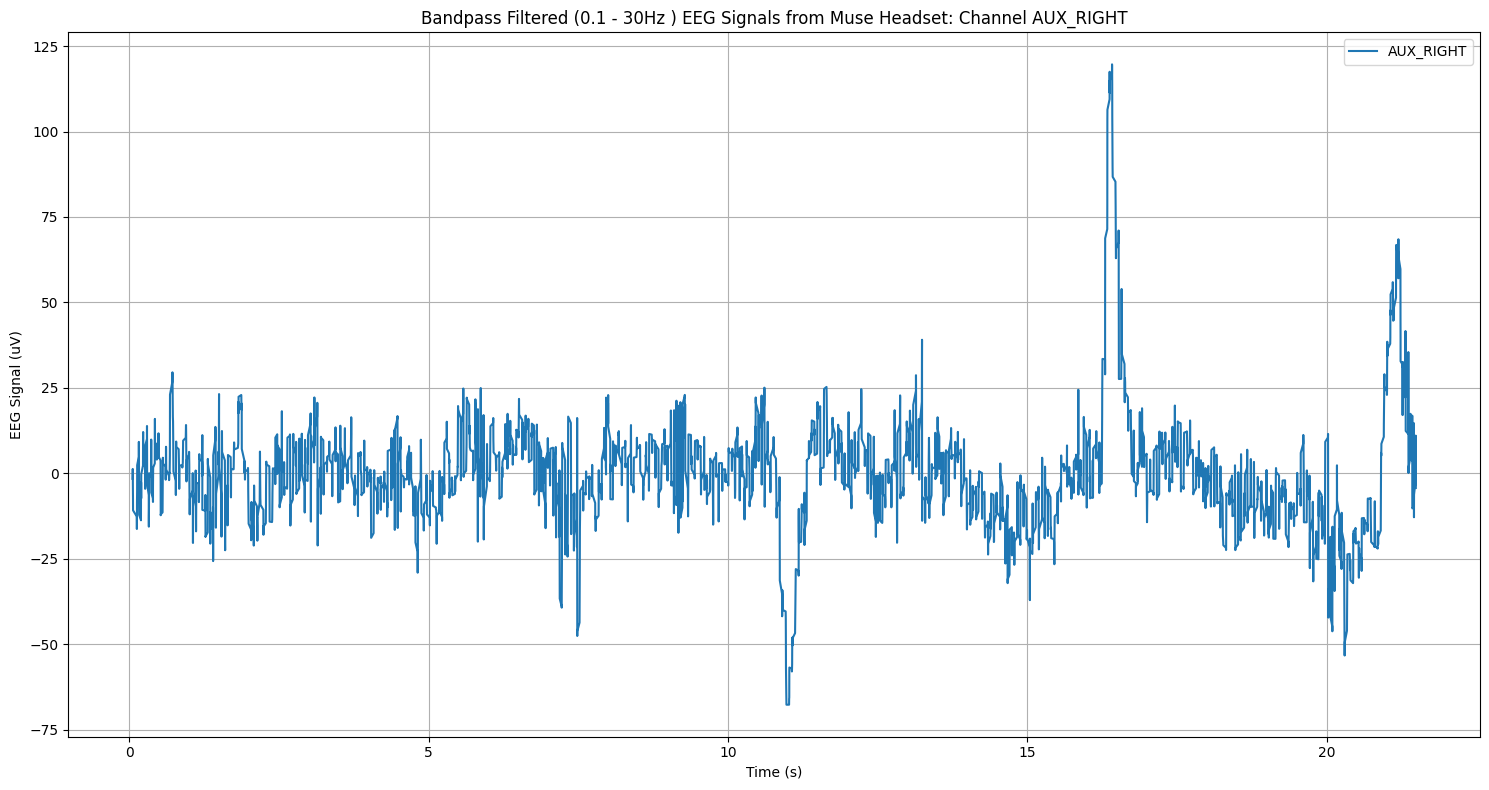

In [ ]:
'''
Using a 0.1-30Hz Butterworth bandpass filter. 

Semi-standard in neuroscience research: 
https://neuraldatascience.io/7-eeg/erp_filtering.html 
'''

time_sec = df["ms_ELAPSED"] / 1000.0
channels = ["TP9_RAW", "AF7_RAW", "AF8_RAW", "TP10_RAW", "AUX_LEFT", "AUX_RIGHT"]

for ch in channels:

    # Define filter parameters
    lowcut = 0.1  # High-pass cutoff frequency
    highcut = 30   # Low-pass cutoff frequency
    sfreq = 500    #sampling freq
    order = 4      # Filter order

    # Calculate Nyquist frequency - for us sfreq/3
    nyquist_freq = sfreq/3

    # Normalize cutoff frequencies
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq

    # Design the Butterworth band-pass filter
    sos = butter(order, [low, high], btype='bandpass', output='sos')

    # Apply the filter using sosfiltfilt for zero-phase filtering
    filtered_data = sosfiltfilt(sos, df[ch])

    print(f"Number of samples: {len(filtered_data)}")

    print(f"Channel: {ch}")
    print(f"Number of samples - time_sec: {len(time_sec)}, filtered_data: {len(filtered_data)}")
    print(f"filtered_data range: {filtered_data.min()} to {filtered_data.max()}")

    plt.figure(figsize=(15, 8))
    plt.plot(time_sec, filtered_data, label=ch)

    #plt.ylim(500,900)

    plt.xlabel("Time (s)")
    plt.ylabel("EEG Signal (uV)")
    plt.title(f"Bandpass Filtered (0.1 - 30Hz ) EEG Signals from Muse Headset: Channel {ch}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

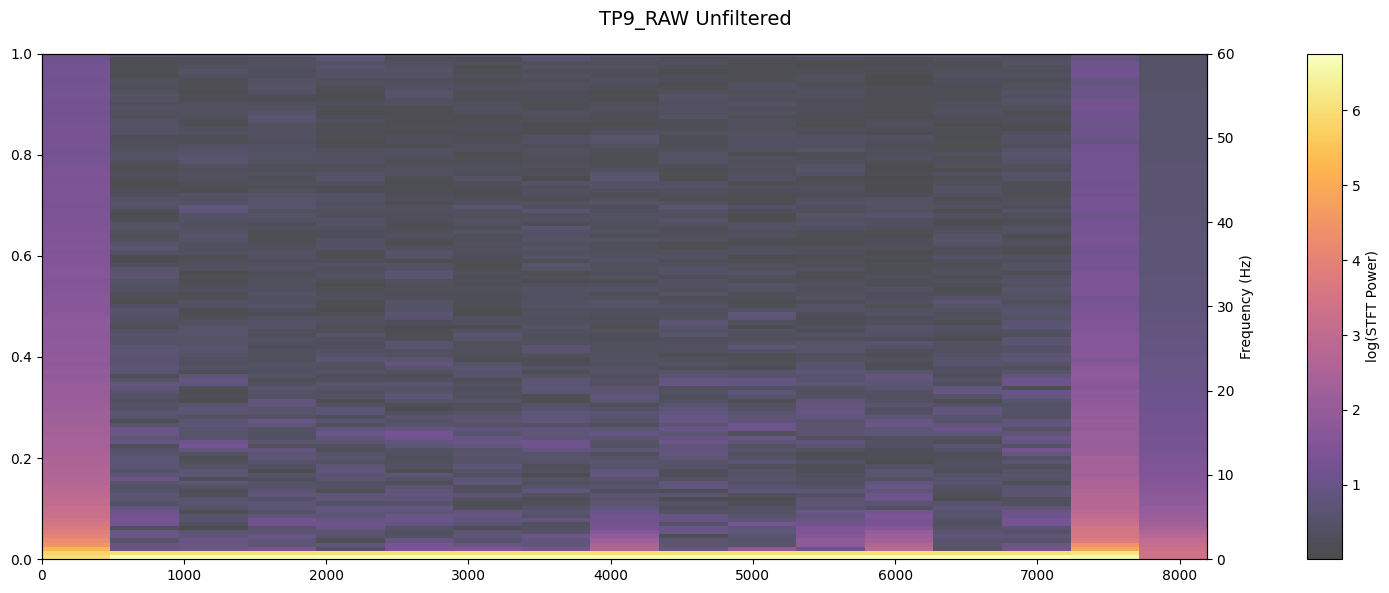

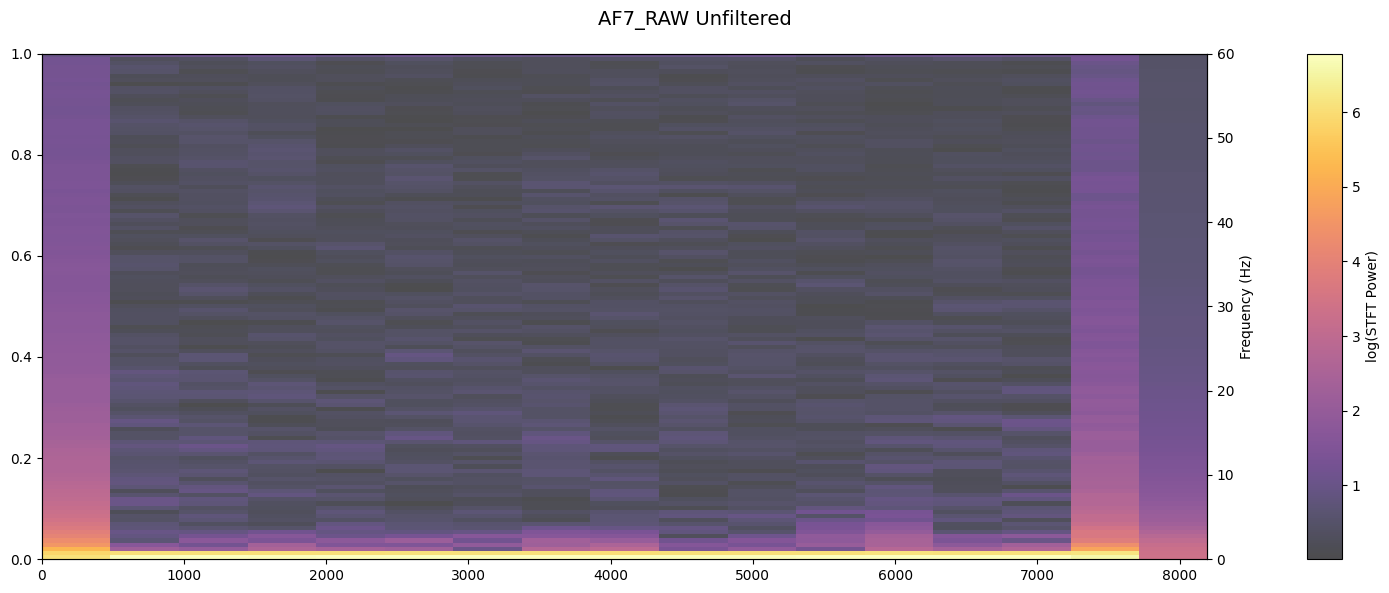

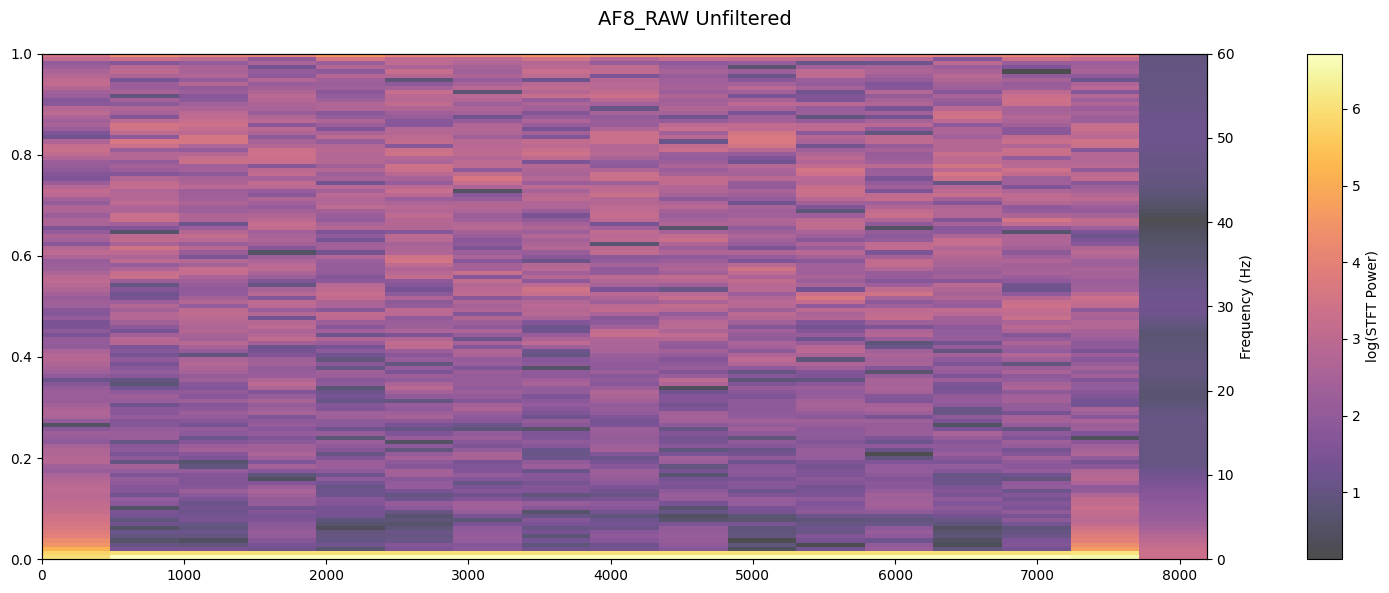

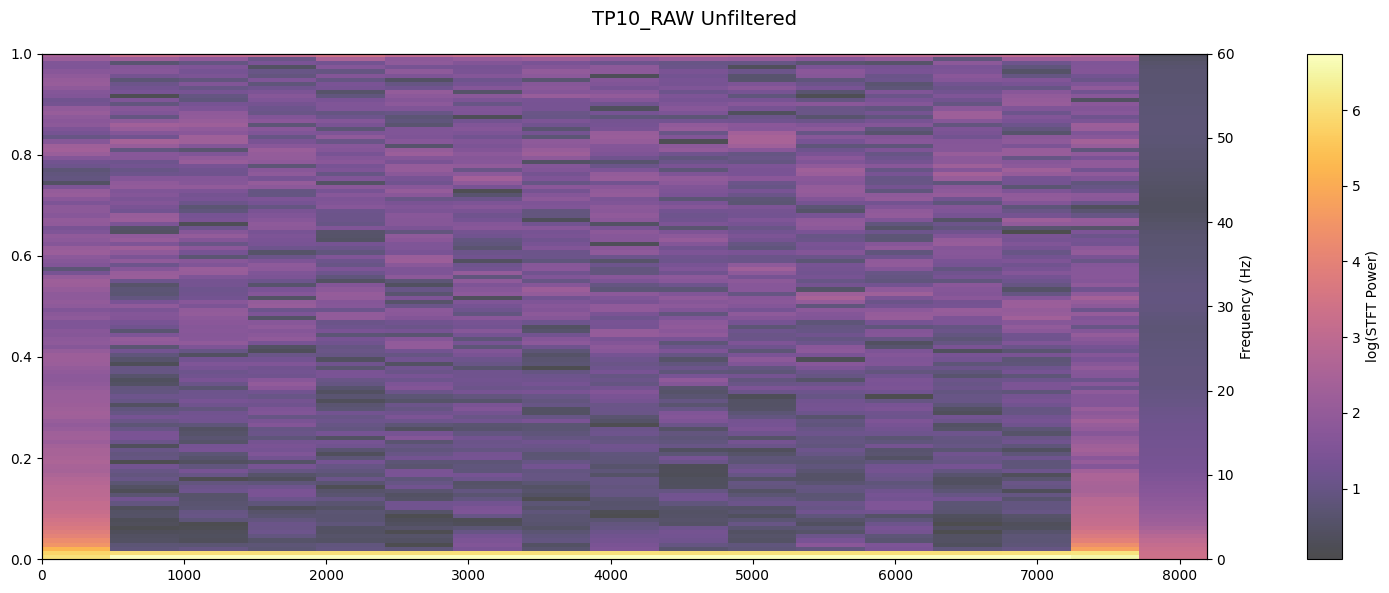

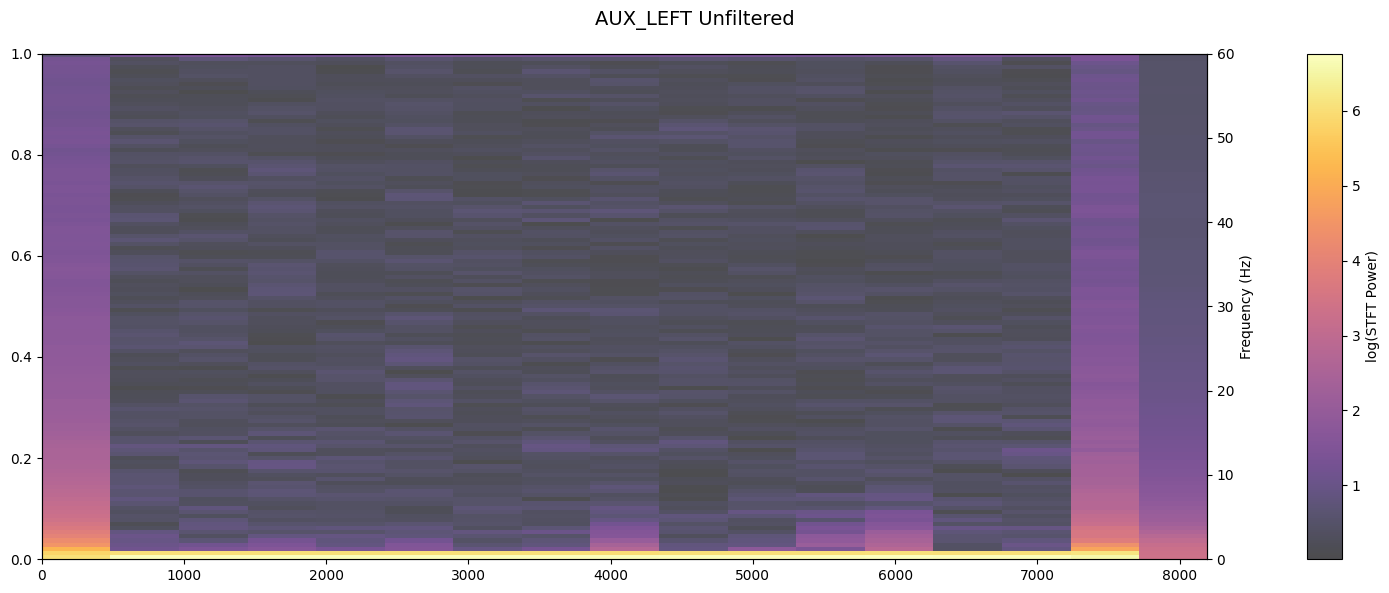

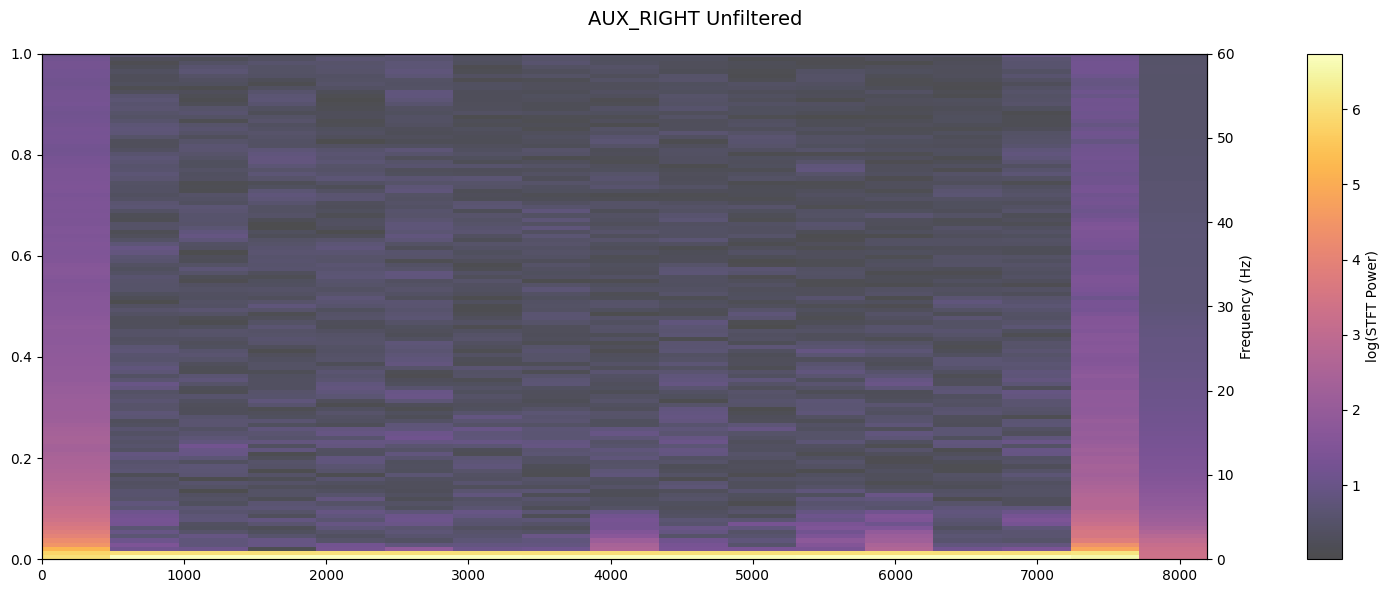

In [ ]:
''' 
Unfiltered EEG STFT - Work in Progress!

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
'''

channels = ["TP9_RAW", "AF7_RAW", "AF8_RAW", "TP10_RAW", "AUX_LEFT", "AUX_RIGHT"]

for channel_name in channels: 

    # Use a representative channel from the Muse data and apply STFT
    fs = 500  # sampling rate
    eeg = df[channel_name].values
    channel_idx = df.columns.get_loc(channel_name)

    nperseg = 1024 #nperseg 
    freq_max = 60 #Max Freq 

    f, t, Zxx = stft(eeg, fs=fs, nperseg=nperseg) #getting results for stft
    power = npy.abs(Zxx)
    global_t = t * fs  # convert to sample index
    power_log = npy.log1p(power)  # log transform for better contrast

    #plottign the graph 
    fig, ax2 = plt.subplots(figsize=(14, 6))

    ax1 = ax2.twinx()
    extent = [global_t[0], global_t[-1], 0, freq_max]
    im = ax1.imshow(power_log[f <= freq_max, :], extent=extent, aspect='auto',
                    origin='lower', cmap='inferno', alpha=0.7)
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_ylim(0, freq_max)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="3%", pad=1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('log(STFT Power)')

    plt.suptitle( (channel_name + " Unfiltered") , fontsize=14, ha='center')
    fig.tight_layout()
    plt.show()

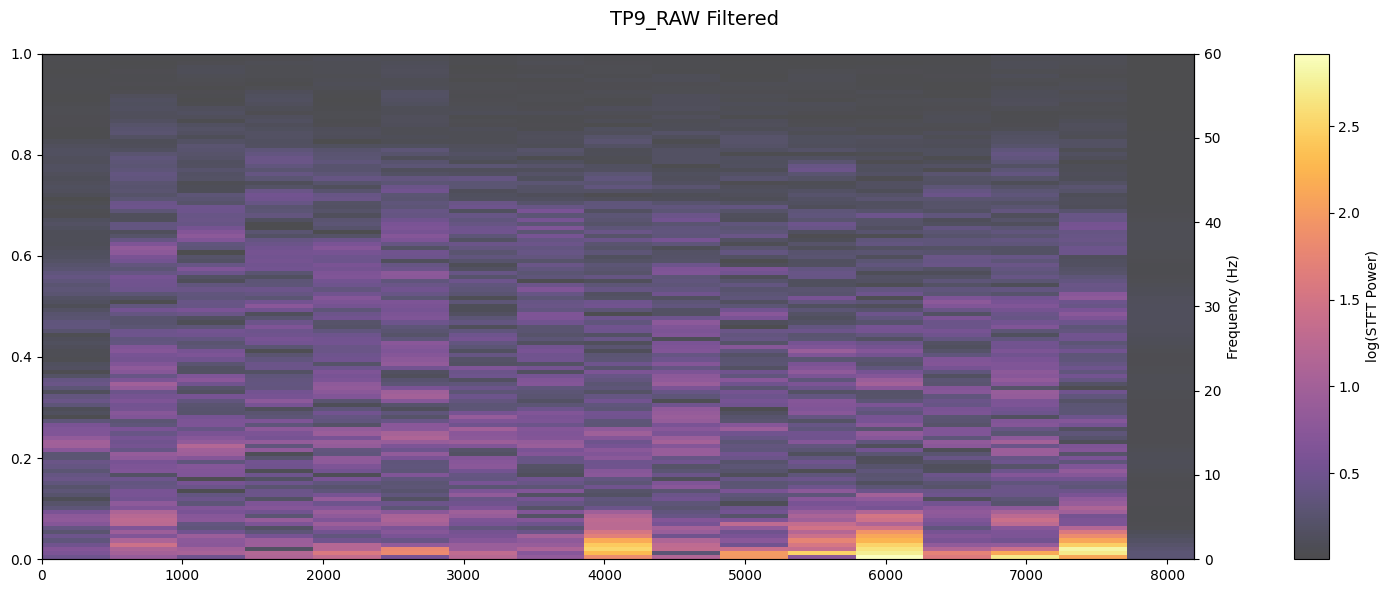

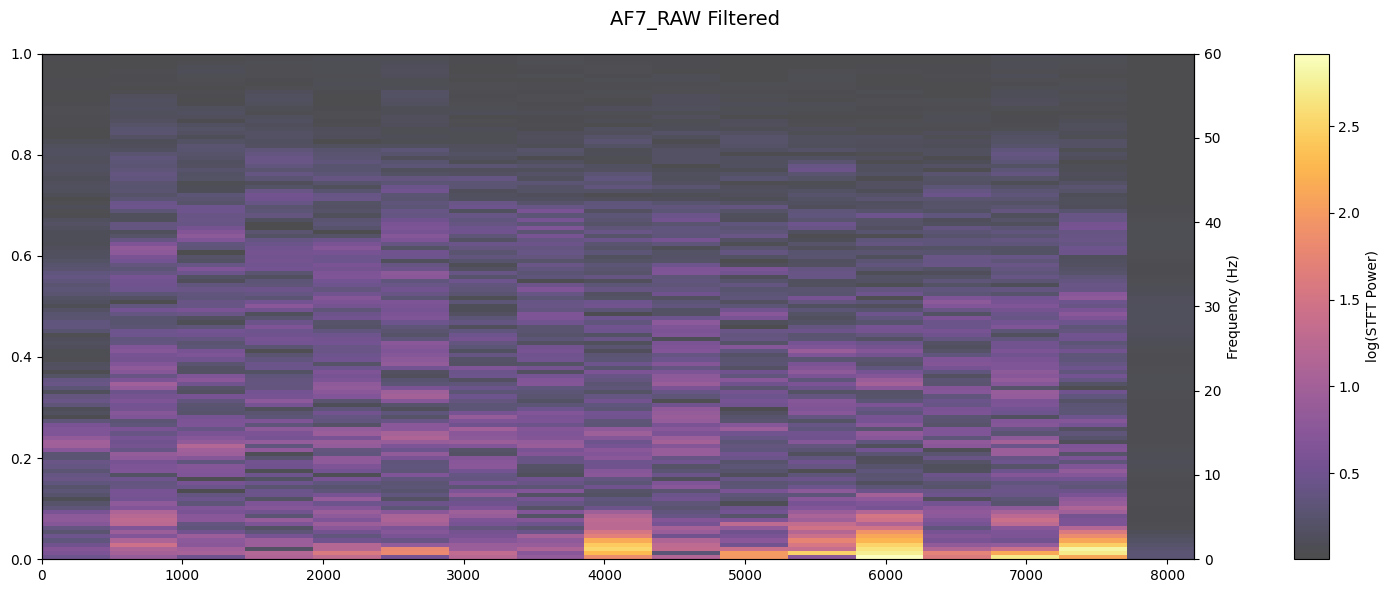

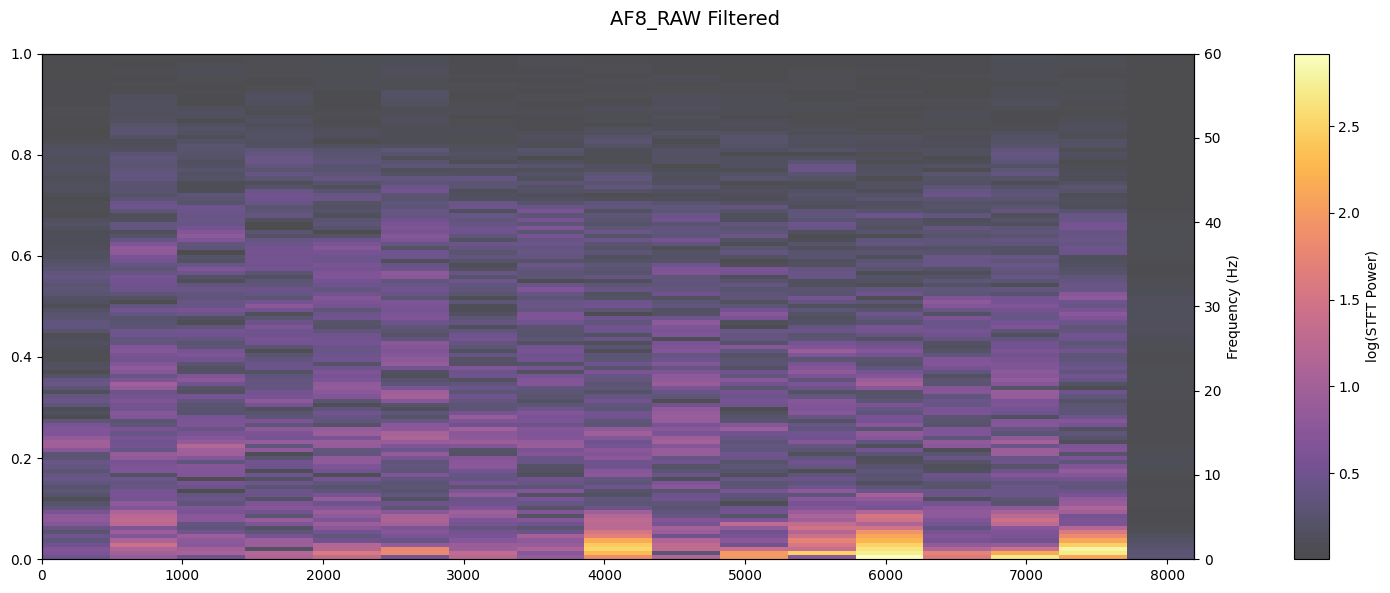

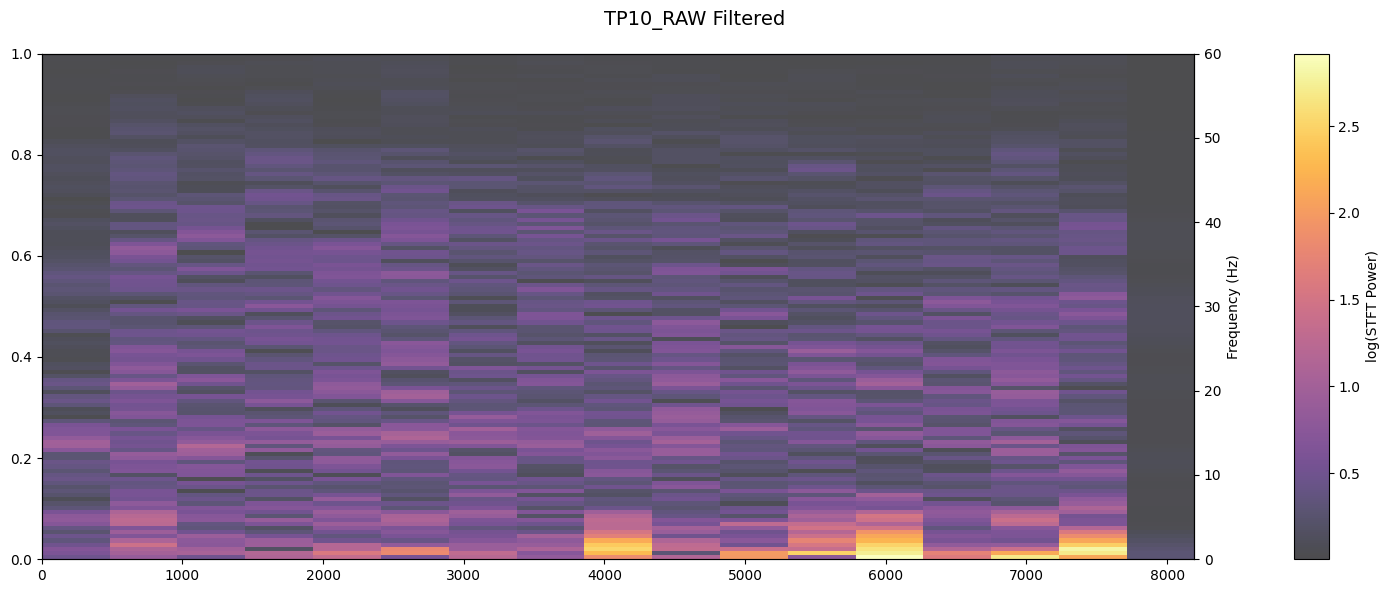

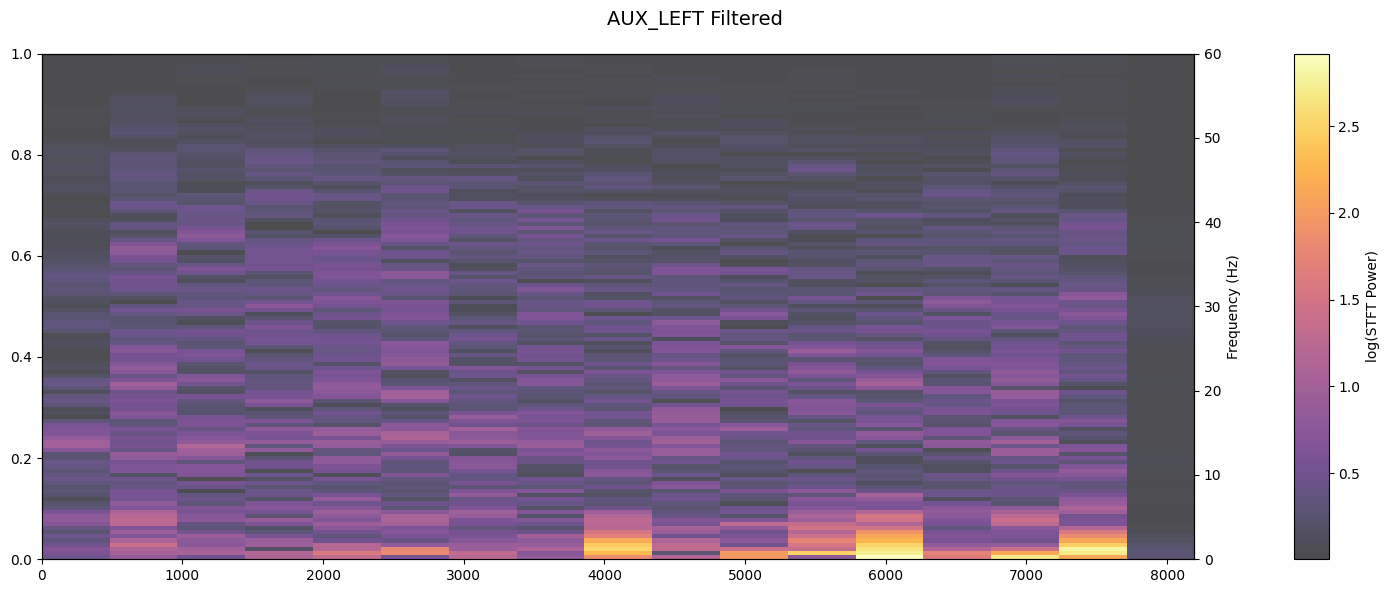

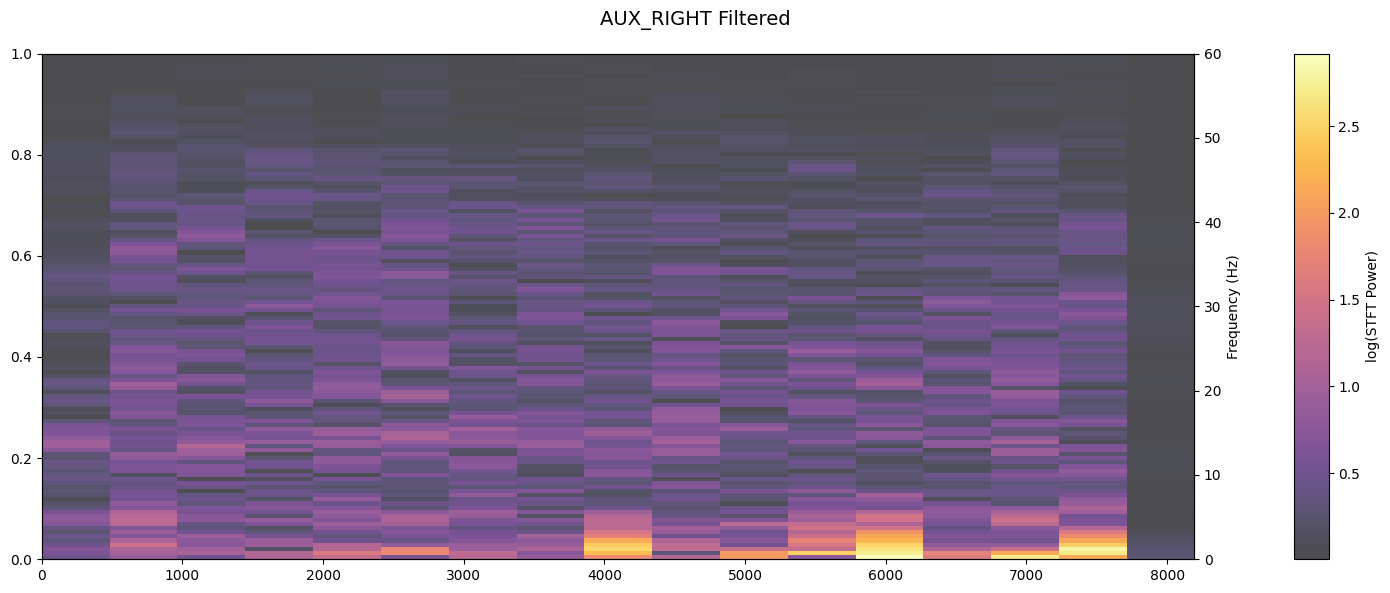

In [ ]:
'''
Filtered STFT - Work in Progress!

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
'''

channels = ["TP9_RAW", "AF7_RAW", "AF8_RAW", "TP10_RAW", "AUX_LEFT", "AUX_RIGHT"]

for channel_name in channels: 

    # Use a representative channel from the Muse data and apply STFT
    #swapping our df row for filtered data
    channel_idx = df.columns.get_loc(channel_name)

    nperseg = 1024 #nperseg 
    freq_max = 60 #Max Freq -  max displayed on graph 

    f, t, Zxx = stft(filtered_data, fs=sfreq, nperseg=nperseg)

    global_t = t * sfreq 

    power = npy.abs(Zxx) #Zxx into absolute values  
    power_log = npy.log1p(power)  # log transform for better contrast

    #plottign the graph 
    fig, ax2 = plt.subplots(figsize=(14, 6))

    ax1 = ax2.twinx()
    #I assume glboal t is time and 0-freqmax is hz range on graph 
    extent = [global_t[0], global_t[-1], 0, freq_max]
    im = ax1.imshow(power_log[f <= freq_max, :], extent=extent, aspect='auto',
                    origin='lower', cmap='inferno', alpha=0.7)
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_ylim(0, freq_max)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="3%", pad=1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('log(STFT Power)')

    plt.suptitle( (channel_name + " Filtered") , fontsize=14, ha='center')
    fig.tight_layout()
    plt.show()